In [1]:
import numpy as np
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

from modelVelocity import ModelVelocity
from logProb import log_prob
from MCMC import MCMC

#from multiprocessing import get_context
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
#Read the measurements. 
data = np.loadtxt("data.dat")
sigma_obs = data[:,0]
sigma_obs_err = data[:,1]
r_ins = data[:,2]
r_outs = data[:,3]
sigma_Bs = data[:,4]

In [3]:
#The data file has as the beam size the major axis instead of the average. The first two are the uniform weighting cube, which has a beam of 0.089" x 0.053", and the natural beam is 0.13" x 0.09".
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
z = 4.6019
DA = cosmo.angular_diameter_distance(z)

beam_FWHM_ang = np.array([[0.13, 0.09],[0.089, 0.053]])*u.arcsec
beam_FWHM_phys = (beam_FWHM_ang.to(u.rad) * DA / u.rad).to(u.kpc)
beam_sigma_phys = beam_FWHM_phys / (2*(2*np.log(2.))**0.5)

#Replace the sigma_B values for the average of both axes.
mean_sigma_phys = np.mean(beam_sigma_phys, axis=1)
sigma_Bs[:2] = mean_sigma_phys[1]
sigma_Bs[2:] = mean_sigma_phys[0]

In [4]:
#Initialize the modeling object
modelv = ModelVelocity(sigma_Bs, r_ins, r_outs)

In [ ]:
#Initial guesses. Order is n, log Mbulge, re bulge, log Mbh
x_init = np.array([4.0, 10.5, 1.5, 10.])

#Set the bounds.
x_min = np.array([0.50,  8., 0.25, 0.])
x_max = np.array([10.0, 12., 10.0, 11.])

#Set which parameters are fixed.
ifix  = np.zeros(x_init.shape, dtype=bool)
#ifix[0] = True
#ifix[2] = True

In [6]:
#Run the MCMC
myMCMC = MCMC(x_init, x_min, x_max, modelv, log_prob, sigma_obs, sigma_obs_err, ifix=ifix)
myMCMC.runMCMC()

100%|██████████| 2000/2000 [02:25<00:00, 13.73it/s]


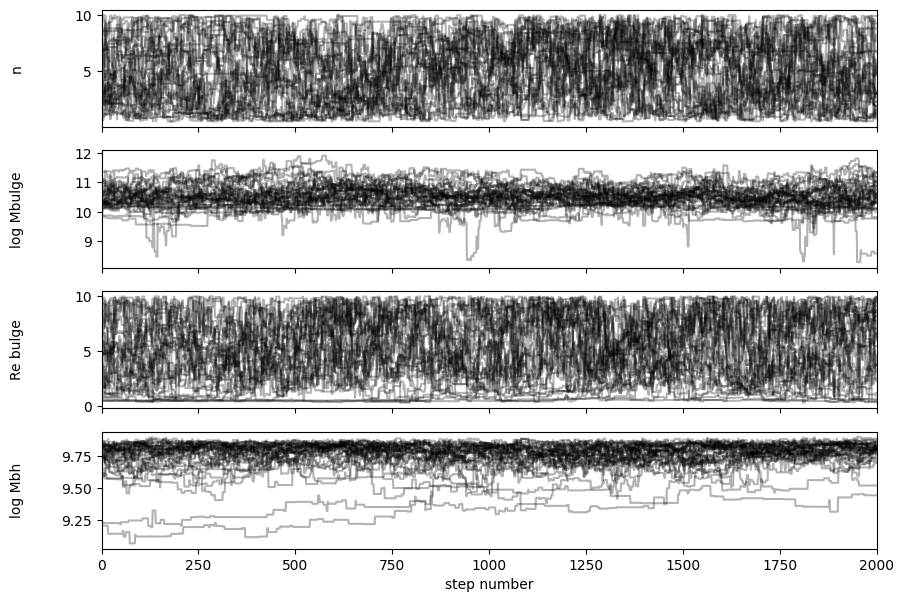

In [7]:
myMCMC.plotConvergence()

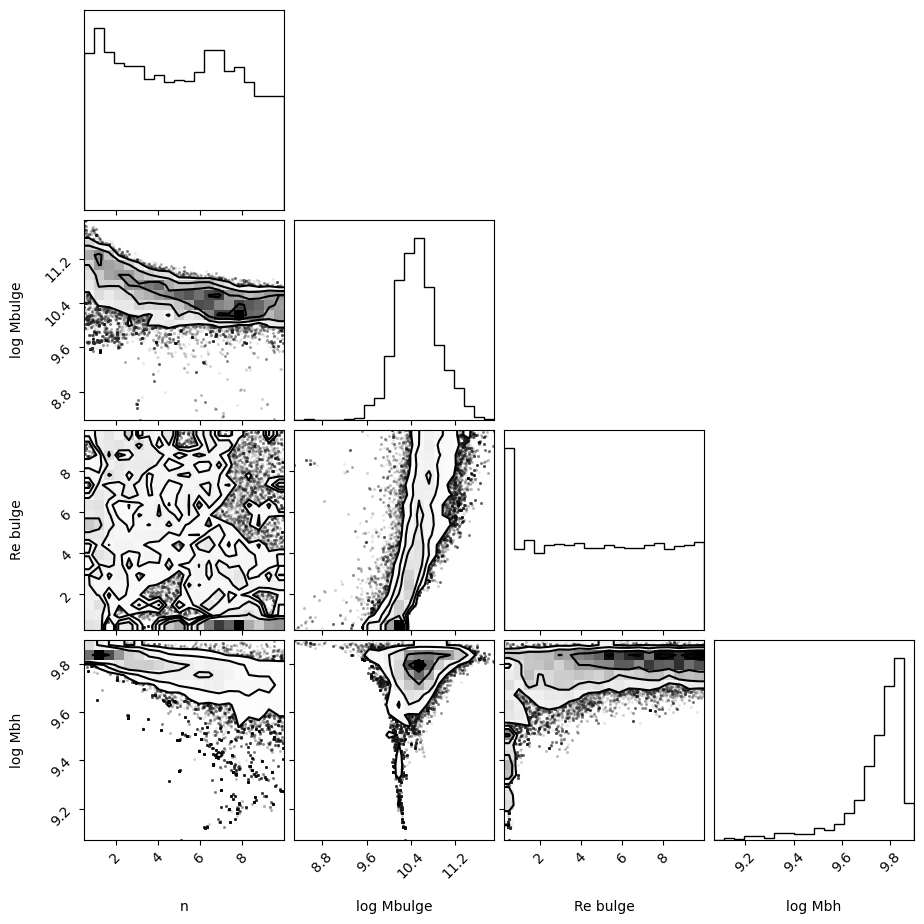

In [8]:
myMCMC.corner_plot()

In [9]:
myMCMC.best_fit()

(array([ 5.0321601 , 10.48848645,  4.84718292,  9.78024673]),
 array([3.27661772, 0.33533489, 3.49842535, 0.12156375]),
 array([3.1615164 , 0.38945456, 3.5269406 , 0.05690935]),
 -2.089654224033515)

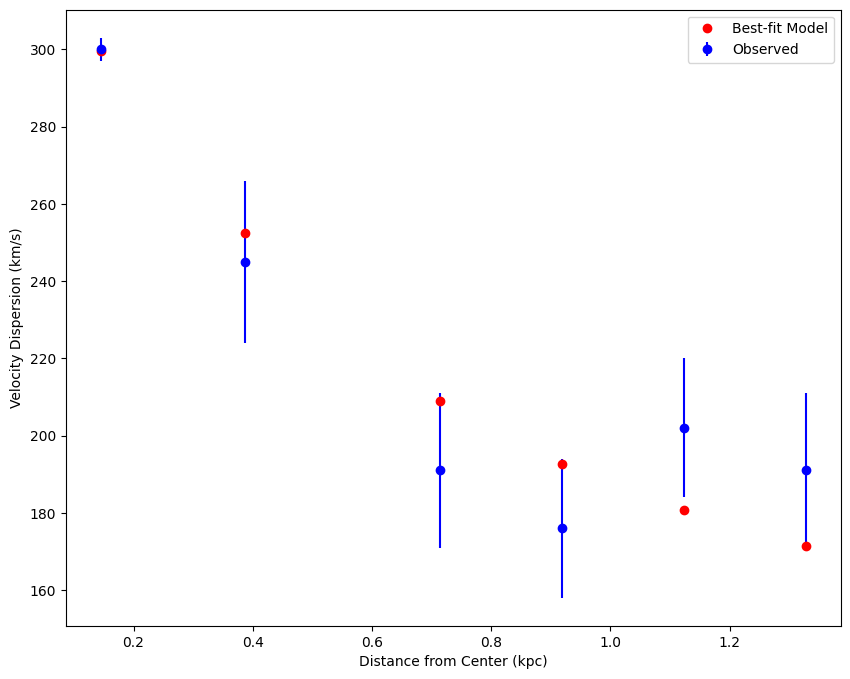

In [10]:
myMCMC.plot_bestfit()

In [ ]:
myMCMC.save_flat_samples("MCMC_flatchain.average_beam.txt")